# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
# откройте данные: ваш код здесь

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('spam_or_not_spam.zip')
display(data.head())


,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


,label,min,max,mean,median,mode,std,sem,lconf,rconf
0,0,5.0,82994.0,1233.67,719.0,83.0,3102.00,62.04,1112.07,1355.27
1,1,1.0,200408.0,2313.67,956.0,"[332.0, 454.0, 487.0, 2973.0]",9817.77,439.50,1452.24,3175.10


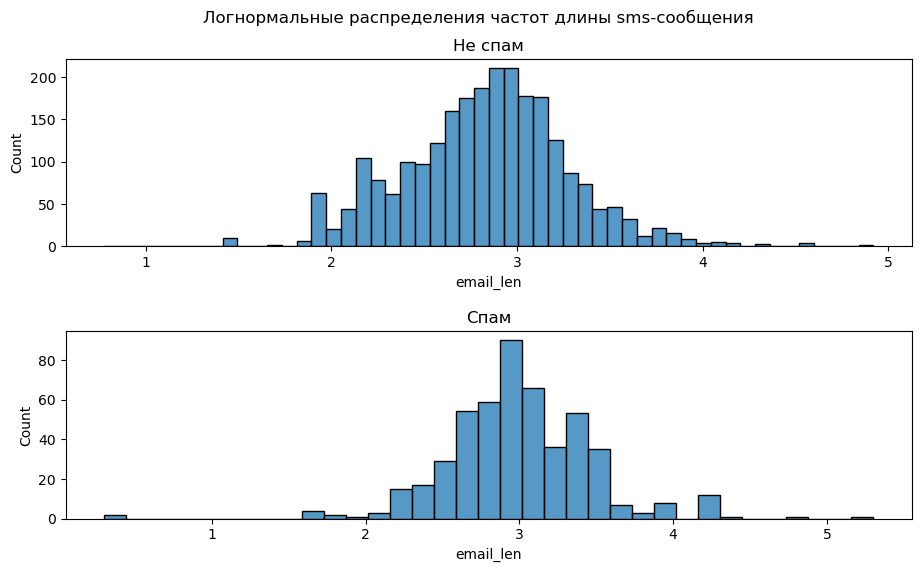

,email,label,email_len
2806,,1,1.0
2828,,1,1.0
2966,NaN,1,NaN


0    0.833333
1    0.166667
Name: label, dtype: float64

0    2500
1     500
Name: label, dtype: int64

In [2]:
# рассчитайте частоты для классов : ваш код здесь

# Для начала рассмотрим данные на наличие пропусков и пустых полей. В качестве ориентира будем использовать данные
# по распределению длины сообщения для "спам/не спам писем"

data['email_len']=data.email.str.len()

groupped=data.groupby('label').email_len.agg(['min', 'max', 'mean', 'median', pd.Series.mode, 'std', 'sem'])
groupped['lconf']=groupped['mean']-1.96*groupped['sem']
groupped['rconf']=groupped['mean']+1.96*groupped['sem']
display(groupped.round(2).reset_index())

# Мы видим что медианно спамовые сообщения более длинные, у них так же значительно выше значение максимальной длины
# письма. На основаннии этой информации можно настроить автоматическое отсечение сообщений с аномальной длиной.
# Распределение ассиметричноt, близко к логнормальному. Посмотрим как оно выглядит на гистограмме.

# Как мы видим, минимальная длина сообщения размеченного как неспамовое равно 5. Будем использовать его для
# для поиска пустых сообщений.

fig, ax=plt.subplots(2, 1, figsize=[10, 6])
fig.tight_layout(pad=4.0)
fig.suptitle('Логнормальные распределения частот длины sms-сообщения')
sns.histplot(np.log10([k.email_len for k in [i[1] for i in data.groupby('label')]][0]+1), ax=ax[0]).set(title='Не спам')
sns.histplot(np.log10([k.email_len for k in [i[1] for i in data.groupby('label')]][1]+1), ax=ax[1]).set(title='Спам')

plt.show()

display(pd.concat([data[data['email_len']<5], data[data.isnull().any(axis=1)]]))

# Итак у нас одно запись с отсутствующим значением и 2 записи с пустыми полями. В зависимости от способа обработки, нам следует либо 
# удалить эти значения, либо рассмотреть целесообразность переразметки этих записей в качестве неспамовых. В пользу последнего свидетельствуют:

# 1) Малое количество пустых сообщений, непохоже на спам-рассылку
# 2) Отсутствие коммерческого интереса спаммеров в рассылке пустых сообщений 

# В данном ноутбуке выбрана стратегия удаления, позволяющая получить результаты сходящиеся с результатами грейдера.

display(data.label.value_counts(normalize=True))
data.label.value_counts()

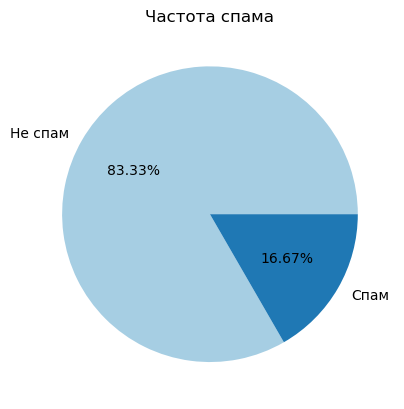

In [3]:
# визуализируйте результат: ваш код здесь

colors = sns.color_palette('Paired')
# [0:5]
plt.pie(data.label.value_counts(True), labels=['Не спам', 'Спам'], colors=colors, autopct='%.02f%%')
plt.title('Частота спама')
plt.show()

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [5]:
#ваш код здесь
data=data[data['email_len']>=5]

Переводим данные в векторный вид:

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [7]:
#ваш код здесь
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [8]:
#ваш код здесь
y=data['label']

Разделите выборку на обучающую и тестовую, размер тестовой выборки возьмите как 0.25, параметр random_state определите со значением 42:

In [9]:
#ваш код здесь
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.75, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [10]:
#ваш код здесь
round(y_test.mean(),3)

0.177

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [11]:
#ваш код здесь
from sklearn.naive_bayes import ComplementNB
model=ComplementNB(alpha=0.01)
# model=MultinomialNB(alpha=0.01)
model.fit(X_train, y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [12]:
#ваш код здесь
from sklearn.metrics import classification_report, roc_curve
target_names = ['Не спам', 'Спам']
train_metrics=pd.DataFrame(classification_report(y_train, y_pred_train, target_names=target_names, output_dict=True)).round(3)
test_metrics= pd.DataFrame(classification_report(y_test, y_pred_test, target_names=target_names, output_dict=True)).round(3)
metrics=pd.concat([train_metrics.iloc[:3,:3], test_metrics.iloc[:3,:3]], axis=1, keys=['TRAIN', 'TEST'])
metrics

TRAIN                    TEST                
          Не спам   Спам accuracy Не спам   Спам accuracy
precision   0.998  1.000    0.999   0.994  0.977    0.991
recall      1.000  0.992    0.999   0.995  0.970    0.991
f1-score    0.999  0.996    0.999   0.994  0.974    0.991

Нарисуйте ROC-кривую:

0.9872107334787535


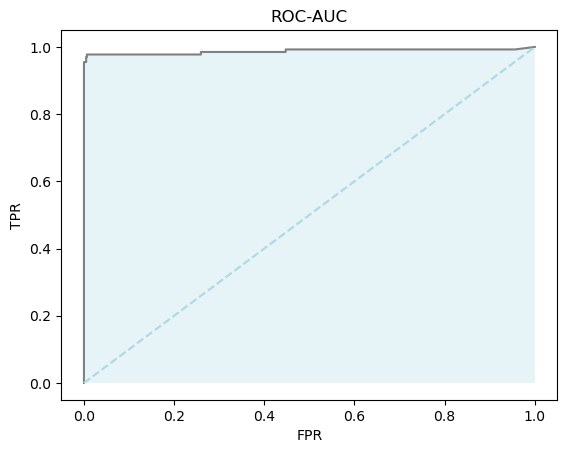

In [13]:
#ваш код здесь
from sklearn import metrics
from sklearn.metrics import auc
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
print(auc(fpr, tpr))
plt.plot(fpr,tpr, color='grey')
plt.title('ROC-AUC')
plt.ylabel('TPR')
plt.xlabel('FPR')
sns.lineplot(x = [0, 1], y = [0, 1], color = 'lightblue', linestyle='--')
plt.fill_between(fpr, tpr, facecolor='lightblue', alpha=0.3)
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

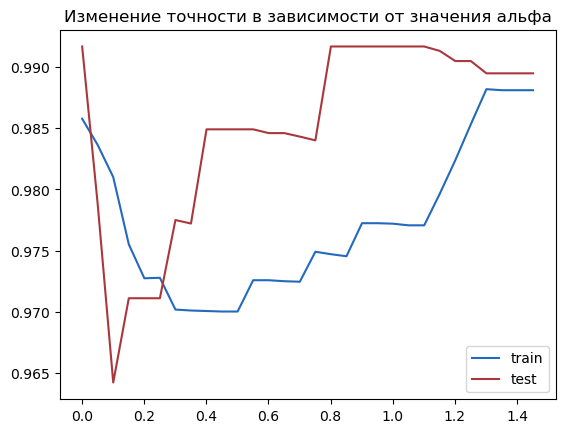

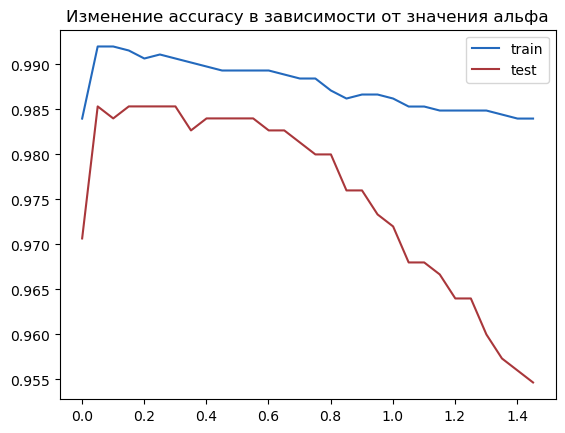

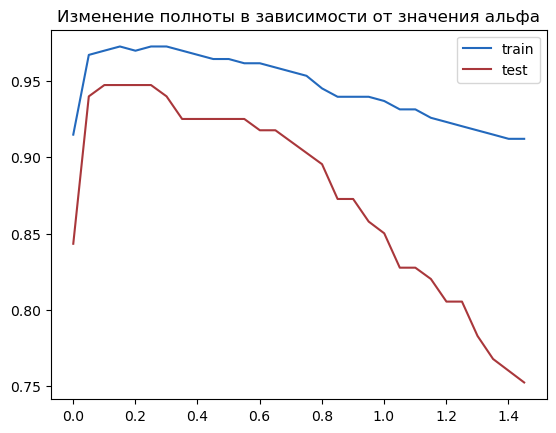

ROC-AUC для компрмиссного значения


TRAIN                    TEST                
          Не спам   Спам accuracy Не спам   Спам accuracy
precision   0.997  0.994    0.996   0.995  0.977    0.992
recall      0.999  0.984    0.996   0.995  0.977    0.992
f1-score    0.998  0.989    0.996   0.995  0.977    0.992

0.990062270749808


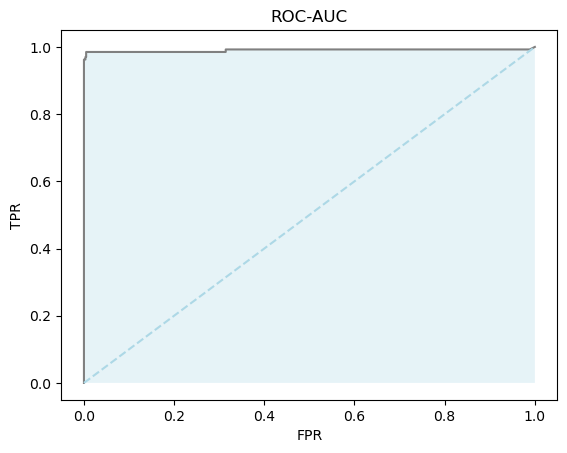

In [17]:
#ваш код здесь
alphadict_train=dict()
alphadict_test=dict()
for alpha in np.arange(0.001, 1.5, 0.05):    
    model = ComplementNB(alpha=alpha)
    alphadict_train[alpha]=(cross_val_score(model, X_train, y_train, cv=5, scoring='precision')).mean()
    alphadict_test[alpha]=(cross_val_score(model, X_test, y_test, cv=5, scoring='precision')).mean()
    
    
pd.DataFrame([alphadict_train, alphadict_test]).T.plot(kind='line', colormap='vlag')
plt.title('Изменение точности в зависимости от значения альфа')
plt.legend(['train', 'test'])
plt.show()

for alpha in np.arange(0.001, 1.5, 0.05):    
    model = ComplementNB(alpha=alpha)
    alphadict_train[alpha]=cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    alphadict_test[alpha]=cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy').mean()
    
pd.DataFrame([alphadict_train, alphadict_test]).T.plot(kind='line', colormap='vlag')
plt.title('Изменение accuracy в зависимости от значения альфа')
plt.legend(['train', 'test'])
plt.show()

# alphadict_train=dict()
# alphadict_test=dict()
for alpha in np.arange(0.001, 1.5, 0.05):    
    model = ComplementNB(alpha=alpha)
    alphadict_train[alpha]=cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    alphadict_test[alpha]=cross_val_score(model, X_test, y_test, cv=5, scoring='recall').mean()
    
pd.DataFrame([alphadict_train, alphadict_test]).T.plot(kind='line', colormap='vlag')
plt.title('Изменение полноты в зависимости от значения альфа')
plt.legend(['train', 'test'])
plt.show()

# Учитывая то что наша задача связана с борьбой со спамом, логично заботиться об улучшении метрики 'precision'. 
# Однако чрезмерно форсируя увеличение этого параметра, мы заваливаем показатель полноты, модель перестаёт "ловить мышей"
# Судя по графикам, компромисс достигается при значениях alpha=0.8


print('ROC-AUC для компрмиссного значения')

model=ComplementNB(alpha=0.8)
model.fit(X_train, y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
target_names = ['Не спам', 'Спам']
train_metrics=pd.DataFrame(classification_report(y_train, y_pred_train, target_names=target_names, output_dict=True)).round(3)
test_metrics= pd.DataFrame(classification_report(y_test, y_pred_test, target_names=target_names, output_dict=True)).round(3)
metric=pd.concat([train_metrics.iloc[:3,:3], test_metrics.iloc[:3,:3]], axis=1, keys=['TRAIN', 'TEST'])
display(metric)
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
print(auc(fpr, tpr))
plt.plot(fpr,tpr, color='grey')
plt.title('ROC-AUC')
plt.ylabel('TPR')
plt.xlabel('FPR')
sns.lineplot(x = [0, 1], y = [0, 1], color = 'lightblue', linestyle='--')
plt.fill_between(fpr, tpr, facecolor='lightblue', alpha=0.3)
plt.show()